Progetto

Configurazione iniziale

Importazione delle librerie necessarie e configurazione dell'ambiente.

In [1]:
# Importazione librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import warnings
import joblib

# Configurazione
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


TASK 1: Implementazione Manuale dei Classificatori

In questa sezione implementiamo manualmente i classificatori decision tree e Naive Bayes.

In [2]:
# Implementazione manuale di Decision Tree
class ManualDecisionTree:
    """Implementazione manuale dell'algoritmo Decision Tree"""
    
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_names = None
    
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.feature_names = [f'feature_{i}' for i in range(self.n_features)]
        
        # Converte y in numerico se necessario
        self.classes_ = np.unique(y)
        self.class_to_num = {cls: i for i, cls in enumerate(self.classes_)}
        y_numeric = np.array([self.class_to_num[cls] for cls in y])
        
        self.tree = self._grow_tree(X, y_numeric)
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Condizioni di stop
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            n_classes == 1):
            most_common_class = Counter(y).most_common(1)[0][0]
            return {'value': most_common_class}
        
        # Trova il miglior split
        best_feat, best_thresh = self._best_split(X, y)
        if best_feat is None:
            most_common_class = Counter(y).most_common(1)[0][0]
            return {'value': most_common_class}
        
        # Crea split
        left_idx = X[:, best_feat] < best_thresh
        X_left, y_left = X[left_idx], y[left_idx]
        X_right, y_right = X[~left_idx], y[~left_idx]
        
        # Ricorsione per creare sottoalberi
        left = self._grow_tree(X_left, y_left, depth+1)
        right = self._grow_tree(X_right, y_right, depth+1)
        
        return {
            'feature': best_feat,
            'threshold': best_thresh,
            'left': left,
            'right': right
        }
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feat, best_thresh = None, None
        
        for feat_idx in range(self.n_features):
            thresholds = np.unique(X[:, feat_idx])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feat_idx, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = threshold
        return best_feat, best_thresh
    
    def _information_gain(self, X, y, feat_idx, threshold):
        parent_entropy = self._entropy(y)
        
        left_idx = X[:, feat_idx] < threshold
        if len(y[left_idx]) == 0 or len(y[~left_idx]) == 0:
            return 0
        
        n = len(y)
        n_left, n_right = len(y[left_idx]), len(y[~left_idx])
        e_left = self._entropy(y[left_idx])
        e_right = self._entropy(y[~left_idx])
        
        child_entropy = (n_left/n)*e_left + (n_right/n)*e_right
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        counts = counts[counts > 0]  # Rimuove gli zeri
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        # Converte da numerico a classe originale
        return np.array([self.classes_[pred] for pred in predictions])
    
    def _predict_single(self, x):
        node = self.tree
        while 'feature' in node:
            if x[node['feature']] < node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

# Implementazione manuale di Naive Bayes
class ManualNaiveBayes:
    """Implementazione manuale di Naive Bayes Gaussiano"""
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9  # evita divisione per zero
            }
    
    def _pdf(self, X, mean, var):
        return np.exp(-(X - mean)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)
    
    def predict(self, X):
        posteriors = []
        for x in X:
            class_probs = []
            for c in self.classes:
                prior = np.log(1.0 / len(self.classes))  # Assume prior uniforme
                likelihood = np.sum(np.log(self._pdf(x, self.parameters[c]['mean'], self.parameters[c]['var'])))
                class_probs.append(prior + likelihood)
            posteriors.append(self.classes[np.argmax(class_probs)])
        return np.array(posteriors)


TASK 1: Caricamento e Valutazione sul Dataset Manuale

Carichiamo il dataset "manuale.csv" e testiamo le prestazioni dei classificatori implementati utilizzando la validazione Leave-One-Out.

Anteprima dataset manuale:
  Stagione             Calciatore Squadra  Età  Partite Giocate  \
0  2024-25        Scott McTominay  Napoli   27               34   
1  2024-25  Alessandro Buongiorno  Napoli   25               22   
2  2024-25       Hakan Çalhanoğlu   Inter   30               29   
3  2024-25           Armando Izzo   Monza   32               30   
4  2024-25             Alex Meret  Napoli   27               34   

   Minuti Giocati  Reti  Assist  Reti Non Su Rigore  Rigori Tirati  \
0           2.938    12       4                  12             12   
1           1.924     1       0                   1              1   
2           1.947     5       6                   2              2   
3           2.435     1       1                   1              1   
4           3.005     0       0                   0              0   

   Ammonizioni  Espulsioni Ruolo?  
0            3           0    Cen  
1            2           0    Dif  
2            5           0    Cen  
3    

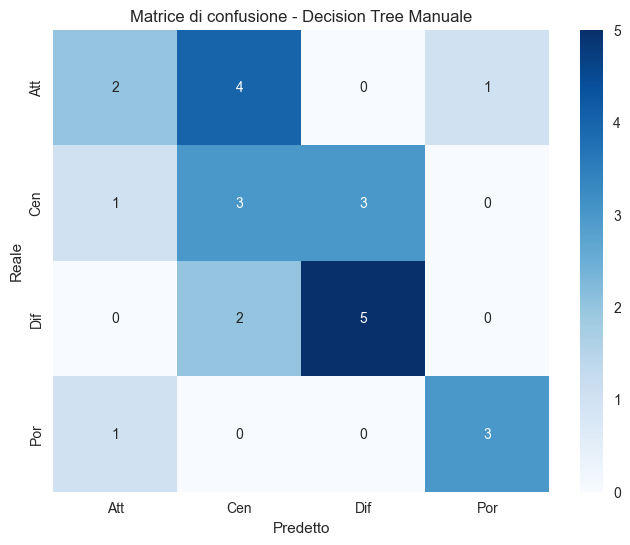

In [3]:
# Caricamento dataset manuale
manuale_df = pd.read_csv('manuale.csv', sep=';')
print("Anteprima dataset manuale:")
print(manuale_df.head())

# Estrazione delle feature e della variabile target
feature_cols = ['Età', 'Partite Giocate', 'Minuti Giocati', 'Reti', 'Assist', 
                'Reti Non Su Rigore', 'Rigori Tirati', 'Ammonizioni', 'Espulsioni']
X_manuale = manuale_df[feature_cols].values
y_manuale = manuale_df['Ruolo?'].values

# Normalizzazione delle feature
scaler = StandardScaler()
X_manuale_scaled = scaler.fit_transform(X_manuale)

print(f"\nDimensioni dataset: {X_manuale.shape}")
print(f"Classi presenti: {np.unique(y_manuale)}")

# Configurazione Leave-One-Out Cross Validation
loo = LeaveOneOut()

# Test Decision Tree Manuale
dt_scores = []
dt_predictions = []
dt_true = []

for train_idx, test_idx in loo.split(X_manuale_scaled):
    X_train_loo, X_test_loo = X_manuale_scaled[train_idx], X_manuale_scaled[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]
    
    dt = ManualDecisionTree(max_depth=5, min_samples_split=2)
    dt.fit(X_train_loo, y_train_loo)
    pred = dt.predict(X_test_loo)
    
    dt_predictions.extend(pred)
    dt_true.extend(y_test_loo)
    dt_scores.append(pred[0] == y_test_loo[0])

dt_accuracy = np.mean(dt_scores)
print(f"\nDecision Tree Manuale - Accuracy: {dt_accuracy:.3f}")

# Test Naive Bayes Manuale
nb_scores = []
nb_predictions = []
nb_true = []

for train_idx, test_idx in loo.split(X_manuale_scaled):
    X_train_loo, X_test_loo = X_manuale_scaled[train_idx], X_manuale_scaled[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]
    
    nb = ManualNaiveBayes()
    nb.fit(X_train_loo, y_train_loo)
    pred = nb.predict(X_test_loo)
    
    nb_predictions.extend(pred)
    nb_true.extend(y_test_loo)
    nb_scores.append(pred[0] == y_test_loo[0])

nb_accuracy = np.mean(nb_scores)
print(f"Naive Bayes Manuale - Accuracy: {nb_accuracy:.3f}")

print(f"\nMigliore classificatore manuale: {'Naive Bayes' if nb_accuracy > dt_accuracy else 'Decision Tree'}")

# Visualizziamo la matrice di confusione per il Decision Tree
plt.figure(figsize=(8, 6))
cm = confusion_matrix(dt_true, dt_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - Decision Tree Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()


TASK 2: Caricamento e Pulizia del Dataset Training

Carichiamo il dataset "training.csv" e lo puliamo rimuovendo valori anomali.

In [4]:
# Caricamento dataset training
training_df = pd.read_csv('training.csv', sep=';')
print(f"Dimensioni dataset originale: {training_df.shape}")
print("Anteprima dataset training:")
print(training_df.head())

# Pulizia dei dati
training_clean = training_df.copy()

# Rimuoviamo "Cantante" da Ruolo
training_clean = training_clean[training_clean['Ruolo?'] != 'Cantante']

# Correggiamo valori non numerici
training_clean['Minuti Giocati'] = training_clean['Minuti Giocati'].replace('?', np.nan)
training_clean['Minuti Giocati'] = pd.to_numeric(training_clean['Minuti Giocati'], errors='coerce')

training_clean['Espulsioni'] = training_clean['Espulsioni'].replace('McFratm', np.nan)
training_clean['Espulsioni'] = pd.to_numeric(training_clean['Espulsioni'], errors='coerce')

# Rimuoviamo outliers estremi (es. età = 1000)
training_clean = training_clean[training_clean['Età'] < 100]

# Rimuoviamo righe con valori mancanti
training_clean = training_clean.dropna()

print(f"Dimensioni dataset pulito: {training_clean.shape}")

# Analisi distribuzione ruoli
print("\nDistribuzione ruoli:")
role_counts = training_clean['Ruolo?'].value_counts()
print(role_counts.head(10))

# Salviamo il dataset pulito
training_clean.to_csv('training_clean.csv', index=False)
print("\nDataset pulito salvato come 'training_clean.csv'")


Dimensioni dataset originale: (2488, 13)
Anteprima dataset training:
  Stagione         Calciatore  Squadra   Età  Partite Giocate Minuti Giocati  \
0  2024-25     James Abankwah  Udinese  20.0              6.0             88   
1  2024-25    Saud Abdulhamid     Roma  25.0              4.0            205   
2  2024-25  Oliver Abildgaard     Como  28.0              1.0              7   
3  2024-25      Tammy Abraham     Roma  26.0              1.0              1   
4  2024-25      Tammy Abraham    Milan  26.0             28.0          1.183   

   Reti  Assist  Reti Non Su Rigore  Rigori Tirati  Ammonizioni Espulsioni  \
0   0.0     0.0                 0.0            0.0          1.0          0   
1   0.0     1.0                 0.0            0.0          0.0          0   
2   0.0     0.0                 0.0            0.0          0.0          0   
3   0.0     0.0                 0.0            0.0          0.0          0   
4   3.0     4.0                 2.0            2.0          

TASK 2: Analisi Esplorativa con Visualizzazioni

Eseguiamo un'analisi esplorativa dei dati con visualizzazioni grafiche come richiesto: boxplot, pairplot e matrice di correlazione.


Statistiche descrittive:
               Età  Partite Giocate  Minuti Giocati         Reti       Assist  \
count  2480.000000      2480.000000     2480.000000  2480.000000  2480.000000   
mean     25.462903        18.926210      172.348169     1.623387     1.129032   
std       4.750176        11.885725      277.263047     3.102020     1.838444   
min      14.000000         1.000000        1.000000     0.000000     0.000000   
25%      22.000000         8.000000        1.898000     0.000000     0.000000   
50%      25.000000        20.000000        3.123000     0.000000     0.000000   
75%      29.000000        30.000000      256.000000     2.000000     2.000000   
max      71.000000        38.000000      998.000000    29.000000    14.000000   

       Reti Non Su Rigore  Rigori Tirati  Ammonizioni   Espulsioni  
count         2480.000000    2480.000000  2480.000000  2480.000000  
mean             1.495968       0.469355     2.664516     0.122984  
std              2.763208       1.487

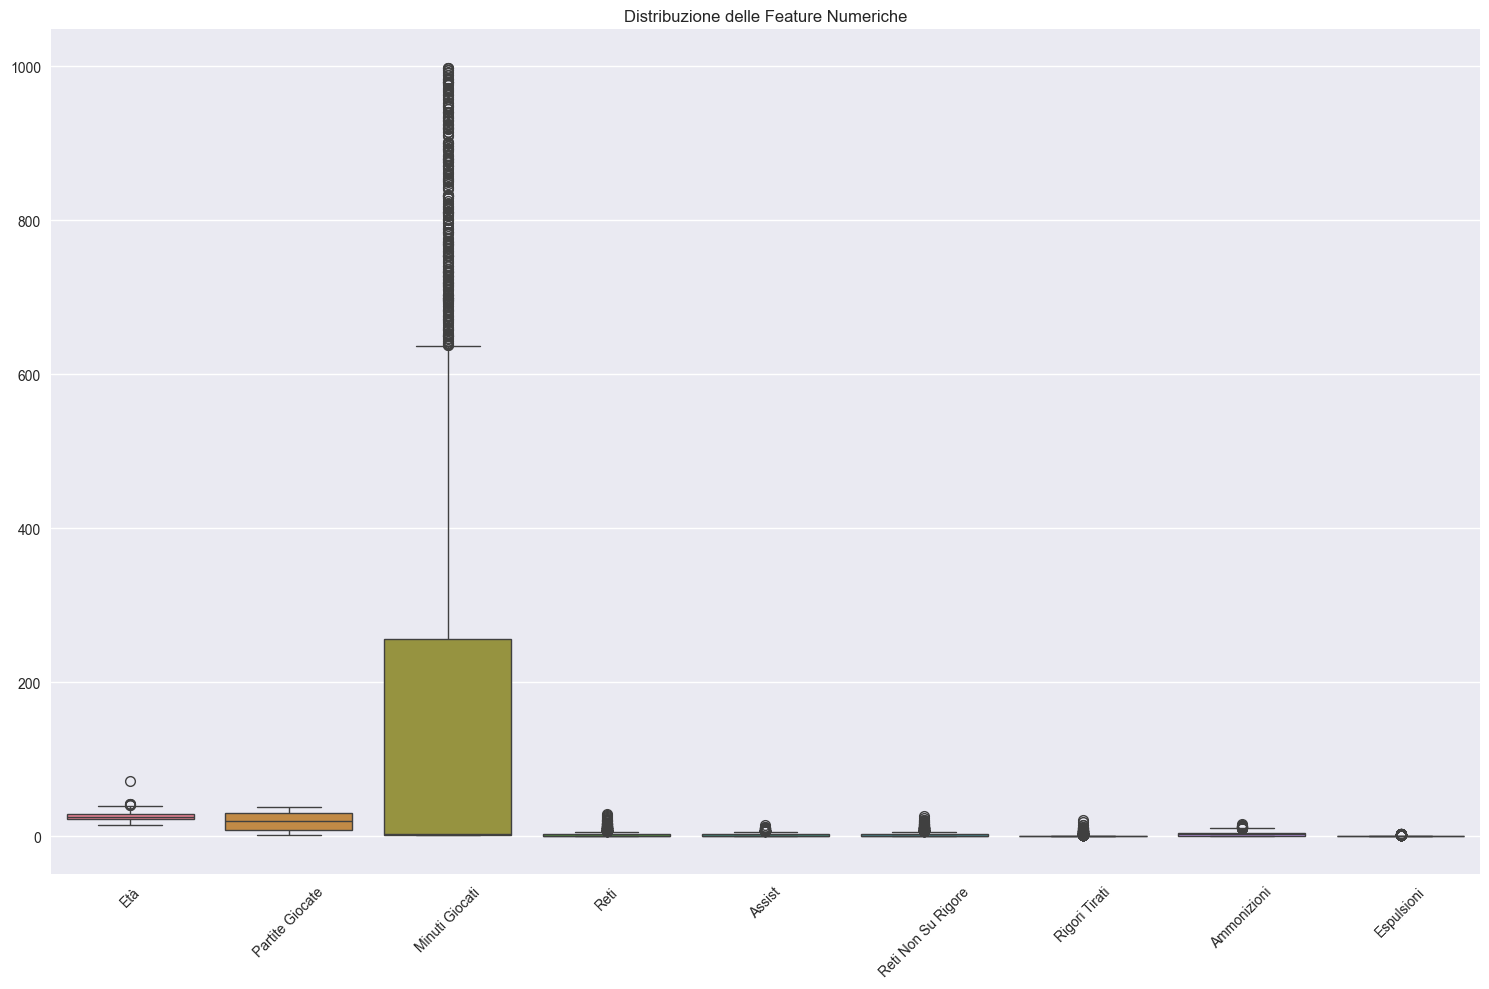

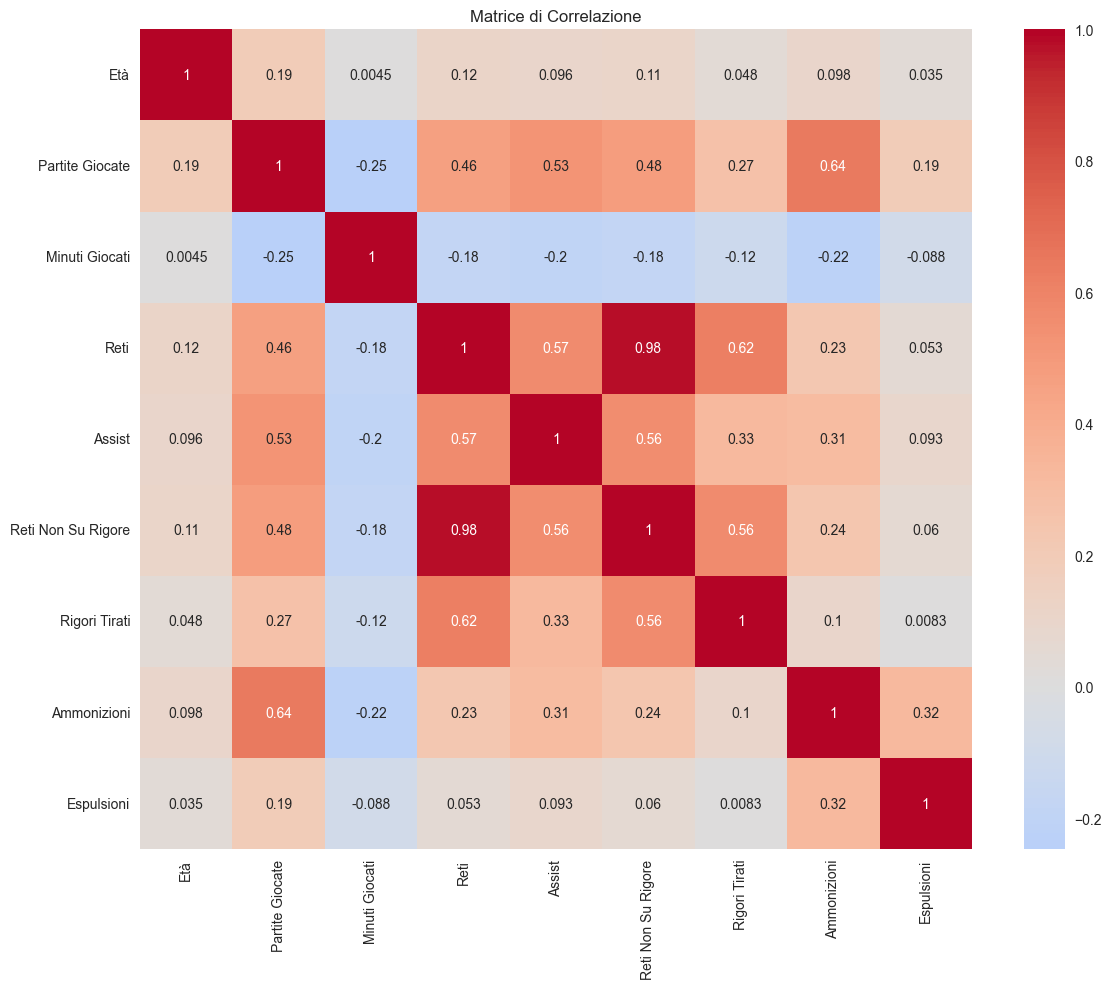

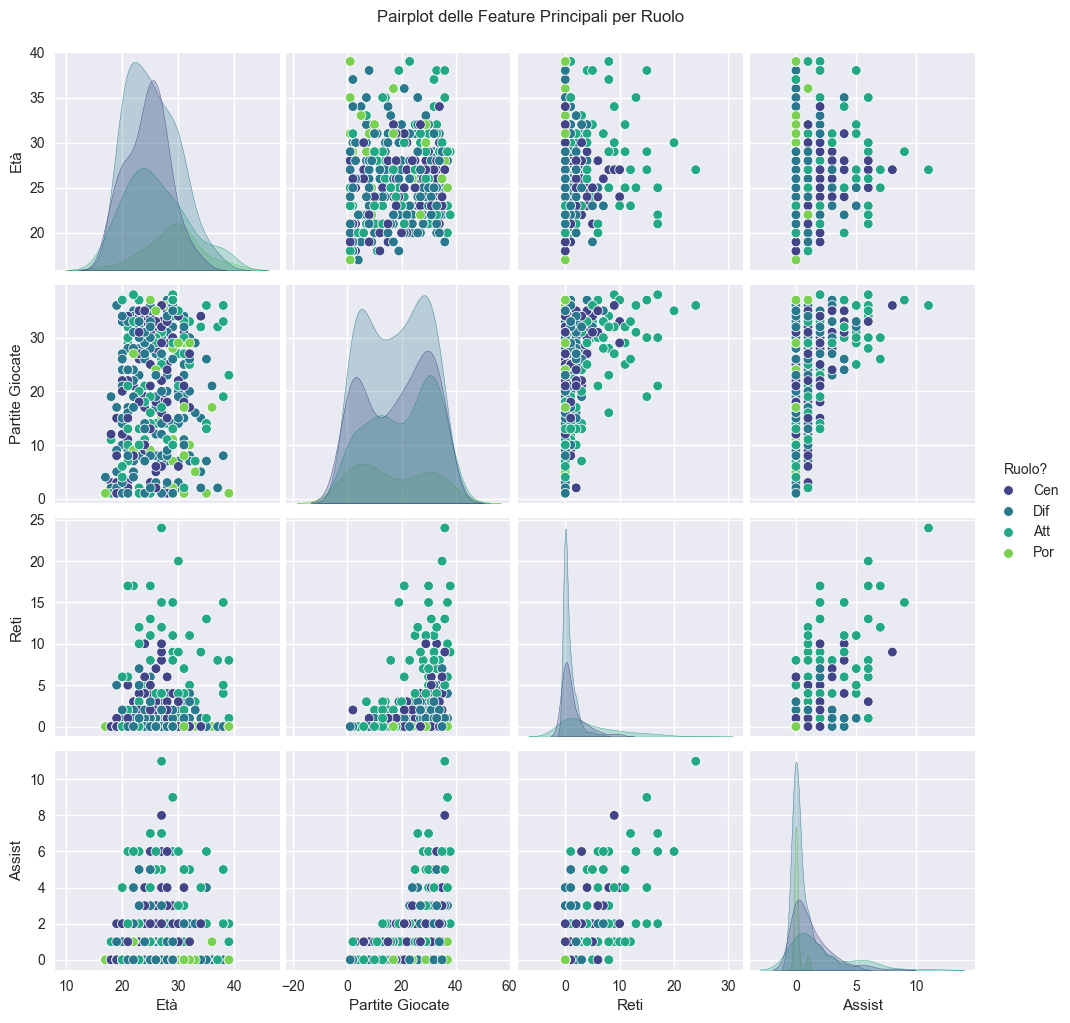

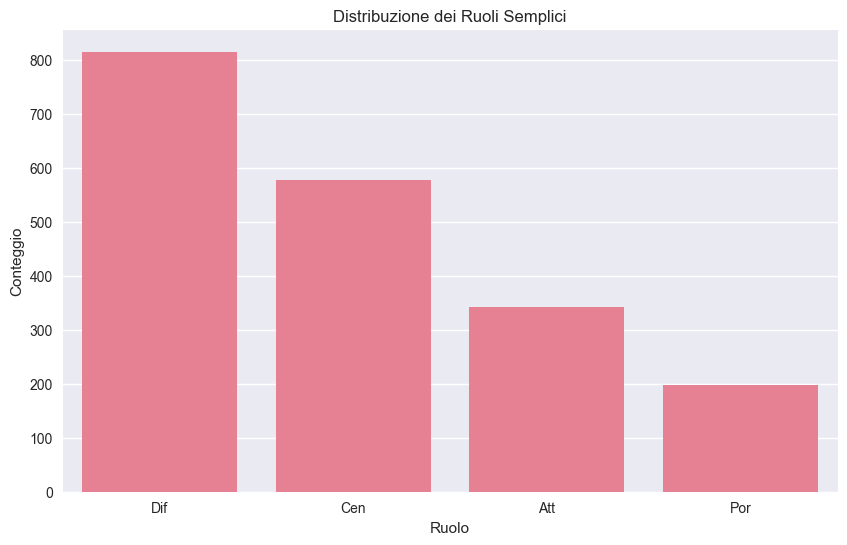

In [5]:
# Statistiche descrittive delle feature numeriche
numeric_features = ['Età', 'Partite Giocate', 'Minuti Giocati', 'Reti', 'Assist', 
                   'Reti Non Su Rigore', 'Rigori Tirati', 'Ammonizioni', 'Espulsioni']

print("\nStatistiche descrittive:")
print(training_clean[numeric_features].describe())

# 1. Boxplot per feature numeriche
plt.figure(figsize=(15, 10))
sns.boxplot(data=training_clean[numeric_features])
plt.title('Distribuzione delle Feature Numeriche')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Matrice di correlazione
plt.figure(figsize=(12, 10))
corr_matrix = training_clean[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.tight_layout()
plt.show()

# 3. Pairplot per le feature principali con ruoli
# Prendiamo un campione più piccolo per rendere il grafico più leggibile
sample_size = 500
if len(training_clean) > sample_size:
    training_sample = training_clean.sample(sample_size, random_state=42)
else:
    training_sample = training_clean

# Filtra solo i ruoli semplici per il pairplot
simple_roles = ['Att', 'Cen', 'Dif', 'Por']
training_simple = training_sample[training_sample['Ruolo?'].isin(simple_roles)]

# Pairplot delle principali feature
main_cols = ['Età', 'Partite Giocate', 'Reti', 'Assist', 'Ruolo?']
sns.pairplot(training_simple[main_cols], hue='Ruolo?', palette='viridis')
plt.suptitle('Pairplot delle Feature Principali per Ruolo', y=1.02)
plt.show()

# Visualizzazione della distribuzione dei ruoli
plt.figure(figsize=(10, 6))
role_counts_simple = training_clean[training_clean['Ruolo?'].isin(simple_roles)]['Ruolo?'].value_counts()
sns.barplot(x=role_counts_simple.index, y=role_counts_simple.values)
plt.title('Distribuzione dei Ruoli Semplici')
plt.xlabel('Ruolo')
plt.ylabel('Conteggio')
plt.show()


TASK 3: Valutazione dei Classificatori Manuali sul Dataset Training

Valutiamo le prestazioni dei classificatori manuali sul dataset training, considerando solo i ruoli semplici.

Dataset con ruoli semplici: (1934, 13)
Train: (1547, 9), Test: (387, 9)

Decision Tree Manuale - Accuracy: 0.527
Report di classificazione Decision Tree Manuale:
              precision    recall  f1-score   support

         Att       0.51      0.62      0.56        69
         Cen       0.39      0.27      0.32       116
         Dif       0.56      0.66      0.60       163
         Por       0.74      0.59      0.66        39

    accuracy                           0.53       387
   macro avg       0.55      0.53      0.53       387
weighted avg       0.52      0.53      0.52       387


Naive Bayes Manuale - Accuracy: 0.382
Report di classificazione Naive Bayes Manuale:
              precision    recall  f1-score   support

         Att       0.65      0.43      0.52        69
         Cen       0.33      0.12      0.18       116
         Dif       0.60      0.40      0.48       163
         Por       0.20      1.00      0.34        39

    accuracy                           0.38  

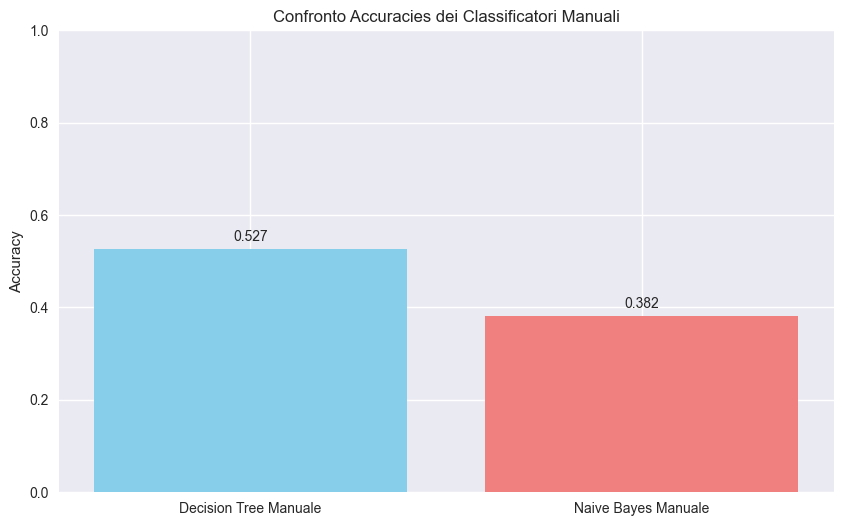

In [6]:
# Filtriamo solo i ruoli semplici
main_roles = ['Att', 'Cen', 'Dif', 'Por']
training_simple = training_clean[training_clean['Ruolo?'].isin(main_roles)].copy()

print(f"Dataset con ruoli semplici: {training_simple.shape}")

# Prepariamo i dati
feature_cols = ['Età', 'Partite Giocate', 'Minuti Giocati', 'Reti', 'Assist', 
                'Reti Non Su Rigore', 'Rigori Tirati', 'Ammonizioni', 'Espulsioni']

X = training_simple[feature_cols].values
y = training_simple['Ruolo?'].values

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Test Decision Tree manuale
dt = ManualDecisionTree(max_depth=7, min_samples_split=3)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"\nDecision Tree Manuale - Accuracy: {dt_acc:.3f}")
print("Report di classificazione Decision Tree Manuale:")
print(classification_report(y_test, dt_pred))

# Test Naive Bayes manuale
nb = ManualNaiveBayes()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)

print(f"\nNaive Bayes Manuale - Accuracy: {nb_acc:.3f}")
print("Report di classificazione Naive Bayes Manuale:")
print(classification_report(y_test, nb_pred))

# Confronto visivo delle performance
plt.figure(figsize=(10, 6))
labels = ['Decision Tree Manuale', 'Naive Bayes Manuale']
accuracies = [dt_acc, nb_acc]
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Confronto Accuracies dei Classificatori Manuali')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Aggiungiamo le etichette di accuracy sopra le barre
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.show()


TASK 4: Modelli Scikit-Learn e Selezione del Migliore

Addestriamo e confrontiamo diversi modelli di machine learning disponibili in scikit-learn.

Random Forest: 0.610
Gradient Boosting: 0.548
SVM: 0.574
Logistic Regression: 0.535
Naive Bayes: 0.382
Decision Tree: 0.548

Migliore modello: Random Forest (0.610)


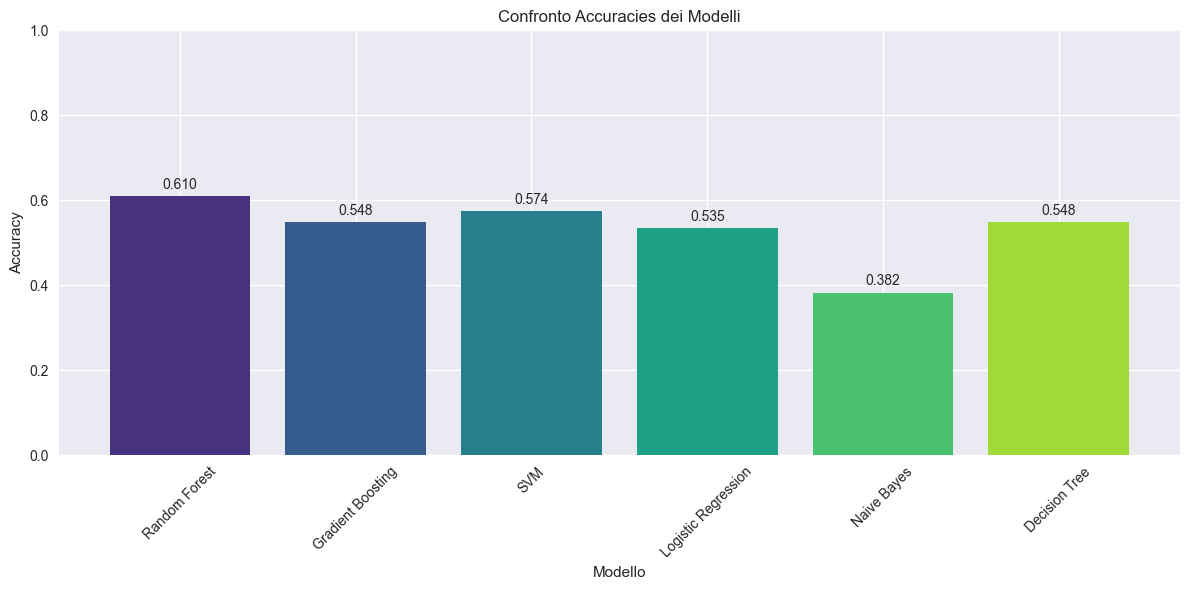

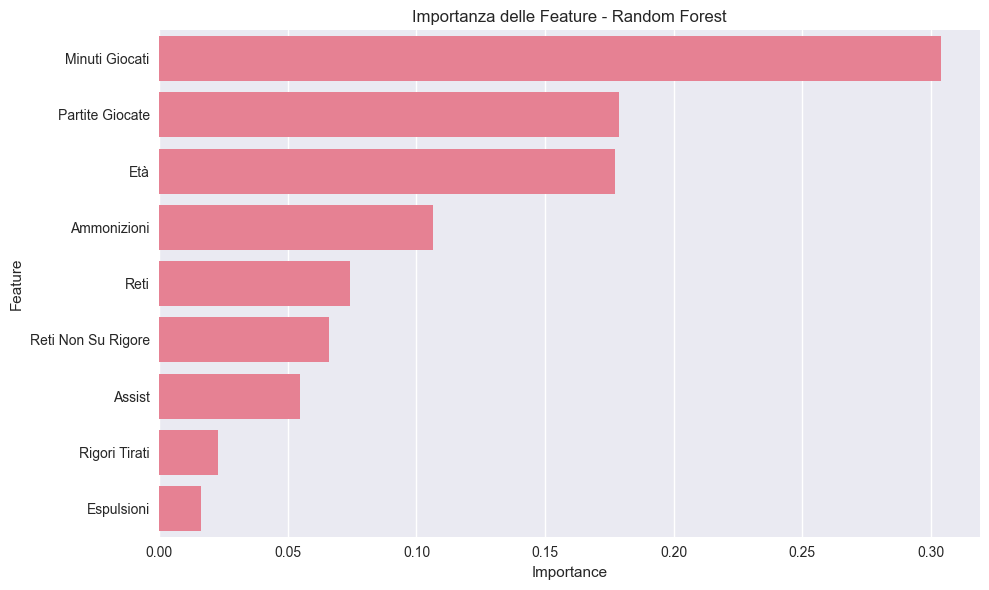

In [7]:
# Modelli da testare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = {}
best_acc = 0
best_model = None
best_name = None

# Addestriamo e valutiamo ogni modello
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = acc
    print(f"{name}: {acc:.3f}")
    
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_name = name

print(f"\nMigliore modello: {best_name} ({best_acc:.3f})")

# Visualizziamo i risultati dei modelli
plt.figure(figsize=(12, 6))
models_names = list(results.keys())
models_accs = list(results.values())
bars = plt.bar(models_names, models_accs, color=sns.color_palette('viridis', len(models)))
plt.title('Confronto Accuracies dei Modelli')
plt.xlabel('Modello')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Aggiungiamo le etichette di accuracy sopra le barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Per Random Forest, vediamo l'importanza delle feature
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    rf_model.fit(X_train, y_train)
    
    # Calcoliamo l'importanza delle feature
    feature_importance = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Importanza delle Feature - Random Forest')
    plt.tight_layout()
    plt.show()


TASK 4: Salvataggio del Modello Migliore e Test su Nuovi Dati

Salviamo il modello migliore e prepariamo il codice per testarlo su nuovi dati (come il futuro file "real_settings.csv").

In [8]:
# Salviamo il modello migliore
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_names.pkl')

print(f"Modello migliore ({best_name}) salvato come 'best_model.pkl'")
print(f"Scaler salvato come 'scaler.pkl'")
print(f"Nomi delle feature salvati come 'feature_names.pkl'")

# Codice per testare il modello su nuovi dati
print("\nCodice per testare il modello su nuovi dati:")
print("""
# Carica il modello e il preprocessore
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')
feature_cols = joblib.load('feature_names.pkl')

# Carica nuovi dati
nuovi_dati = pd.read_csv('real_settings.csv', sep=';')

# Estrai le feature
X_new = nuovi_dati[feature_cols].values

# Normalizza i dati
X_new_scaled = scaler.transform(X_new)

# Fai la predizione
predictions = model.predict(X_new_scaled)
probabilities = model.predict_proba(X_new_scaled)

# Aggiungi le predizioni al dataframe
nuovi_dati['Ruolo_Predetto'] = predictions

# Stampa i risultati
print(nuovi_dati[['Calciatore', 'Ruolo_Predetto']])
""")

# Esempio di predizione con un giocatore inventato
print("\nEsempio di predizione con dati inventati:")
nuovo_giocatore = pd.DataFrame({
    'Età': [25],
    'Partite Giocate': [30],
    'Minuti Giocati': [2500],
    'Reti': [12],
    'Assist': [4],
    'Reti Non Su Rigore': [10],
    'Rigori Tirati': [2],
    'Ammonizioni': [3],
    'Espulsioni': [0]
})

nuovo_giocatore_scaled = scaler.transform(nuovo_giocatore)
predizione = best_model.predict(nuovo_giocatore_scaled)
probabilita = best_model.predict_proba(nuovo_giocatore_scaled)

print(f"Nuovo giocatore:")
print(nuovo_giocatore)
print(f"\nRuolo predetto: {predizione[0]}")
print(f"Probabilità per classe:")
for i, classe in enumerate(best_model.classes_):
    print(f"  {classe}: {probabilita[0][i]:.3f}")


Modello migliore (Random Forest) salvato come 'best_model.pkl'
Scaler salvato come 'scaler.pkl'
Nomi delle feature salvati come 'feature_names.pkl'

Codice per testare il modello su nuovi dati:

# Carica il modello e il preprocessore
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')
feature_cols = joblib.load('feature_names.pkl')

# Carica nuovi dati
nuovi_dati = pd.read_csv('real_settings.csv', sep=';')

# Estrai le feature
X_new = nuovi_dati[feature_cols].values

# Normalizza i dati
X_new_scaled = scaler.transform(X_new)

# Fai la predizione
predictions = model.predict(X_new_scaled)
probabilities = model.predict_proba(X_new_scaled)

# Aggiungi le predizioni al dataframe
nuovi_dati['Ruolo_Predetto'] = predictions

# Stampa i risultati
print(nuovi_dati[['Calciatore', 'Ruolo_Predetto']])


Esempio di predizione con dati inventati:
Nuovo giocatore:
   Età  Partite Giocate  Minuti Giocati  Reti  Assist  Reti Non Su Rigore  \
0   25               30            2500  